In [1]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

import sys
sys.path.append('../')
import utils
from models import wGPLDS, WeightSpaceGaussianProcess

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
n_neurons = 10
latent_dim = 2
peaks = jnp.linspace(-jnp.pi, jnp.pi, n_neurons + 1)[:-1]  # tuning curve peaks
widths = 0.1 * jnp.ones(n_neurons)  # tuning curve widths
epsilon = 0.1
noise_scale = 0.1

In [3]:
@partial(jax.vmap, in_axes=(0, 0))
def dynamics(theta, omega):
    theta = (theta % (2 * jnp.pi)) - jnp.pi
    u = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    v = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    A = (1 - epsilon) * v[:, None] * v[None, :]
    b = u + omega * v
    z = jnp.clip(theta - peaks, -jnp.pi * widths, jnp.pi * widths)
    C = (1 + jnp.cos(z / widths))[:, None] * (
        jnp.tile(u[None, :], (n_neurons, 1))
    )
    return (A, b, C)

def initial_condition(theta, omega):
    m0 = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    S0 = noise_scale * jnp.eye(2)
    return (m0, S0)

def run_dynamics(key, As, bs, Cs, m0, S0):

    def f(x, inp):
        A, b, C, (subkey1, subkey2) = inp
        emission_noise = noise_scale * (
            jxr.multivariate_normal(subkey2, jnp.zeros(n_neurons), jnp.eye(n_neurons))
        )
        y = C @ x + emission_noise

        dynamics_noise = noise_scale * (
            jxr.multivariate_normal(subkey1, jnp.zeros(2), jnp.eye(2))
        )
        x_next = A @ x + b + dynamics_noise
        return x_next, (x_next, y)

    x_init = jxr.multivariate_normal(key, m0, S0)
    subkeys = jxr.split(key, num=(As.shape[0],2))
    _, (x_nexts, ys) = jax.lax.scan(f, x_init, xs=(As, bs, Cs, subkeys))
    # print(x_init)
    # print(x_nexts[0])
    xs = jnp.concatenate([x_init[None, :], x_nexts[:-1]], axis=0)
    return xs, ys

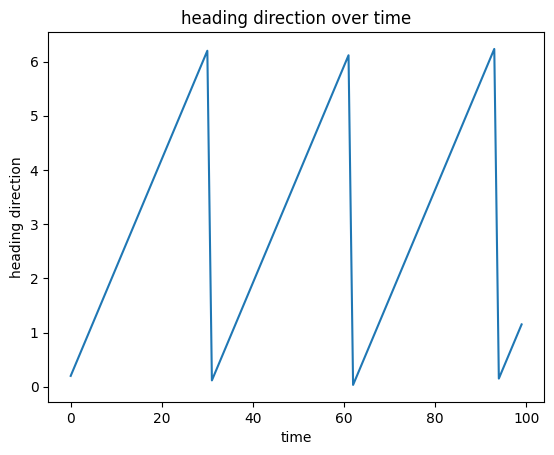

In [4]:
# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

# Plot heading direction trajectory
plt.plot(theta % (2 * jnp.pi))
plt.ylabel('heading direction')
plt.xlabel('time')
plt.title('heading direction over time');

Text(0.5, 0.98, 'True params')

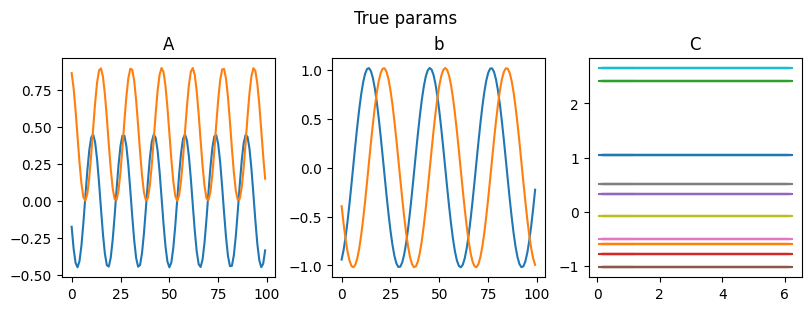

In [5]:
# Generate time-varying linear dynamics and initial condition

true_As, true_bs, true_Cs = dynamics(theta, omega)
# true_bs = jnp.ones((num_timesteps, 2))
# true_Cs = jnp.tile(jnp.eye(2), (num_timesteps, 1, 1))
true_C = jxr.normal(jxr.PRNGKey(0), (n_neurons, 2))
true_Cs = jnp.tile(true_C, (num_timesteps, 1, 1))
true_m0, true_S0 = initial_condition(theta[0], omega[0])

# Run the dynamics to get a batch of data

B = 100
X, Y = jax.vmap(
    lambda i: run_dynamics(jxr.PRNGKey(i), true_As, true_bs, true_Cs, true_m0, true_S0)
    )(jnp.arange(B))

partition = int(0.8 * B)
X_train, Y_train = X[:partition], Y[:partition]
X_test, Y_test = X[partition:], Y[partition:]

# Plot
fig, axs = plt.subplots(ncols=3, figsize=[8,3], constrained_layout=True)
axs[0].plot(true_As[:,1]);
axs[1].plot(true_bs);
axs[2].plot(theta % (2 * jnp.pi), true_Cs[:,:,0], '-');
axs[0].set_title("A")
axs[1].set_title("b")
axs[2].set_title("C")
fig.suptitle("True params")

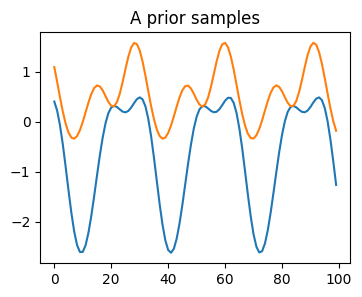

In [6]:
# Define model

_sigma, _kappa, _period = 1.0, 0.2, 2*jnp.pi
torus_basis_funcs = utils.torus_basis(4, _sigma, _kappa, _period)
constant_basis = [lambda x: jnp.ones_like(x)/_period]

A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)
C_prior = WeightSpaceGaussianProcess(constant_basis, D1=n_neurons, D2=latent_dim)
model = wGPLDS(
    wgps={
        'A': A_prior, 
        'b': b_prior,
        'C': None, #C_prior,
        }, 
    state_dim=latent_dim, 
    emission_dim=n_neurons,
    )

fig, ax = plt.subplots(figsize=[4,3])
ax.plot(A_prior.sample(jxr.PRNGKey(0), theta)[:,0,0]);
ax.plot(A_prior.sample(jxr.PRNGKey(0), theta)[:,0,1]);
ax.set_title('A prior samples');

Iter 1/100, log-prob = -1156921.38, marginal log-lik = -1160159.50
Iter 2/100, log-prob = -9528.84, marginal log-lik = -12567.65
Iter 3/100, log-prob = 15495.02, marginal log-lik = 12300.41
Iter 4/100, log-prob = 19706.59, marginal log-lik = 16488.84
Iter 5/100, log-prob = 23146.37, marginal log-lik = 19918.76
Iter 6/100, log-prob = 26486.25, marginal log-lik = 23252.69
Iter 7/100, log-prob = 30534.76, marginal log-lik = 27299.87
Iter 8/100, log-prob = 34821.45, marginal log-lik = 31583.90
Iter 9/100, log-prob = 38024.98, marginal log-lik = 34784.86
Iter 10/100, log-prob = 40346.47, marginal log-lik = 37104.43
Iter 11/100, log-prob = 42097.13, marginal log-lik = 38853.80
Iter 12/100, log-prob = 43316.60, marginal log-lik = 40072.56
Iter 13/100, log-prob = 44083.18, marginal log-lik = 40838.71
Iter 14/100, log-prob = 44526.50, marginal log-lik = 41281.58
Iter 15/100, log-prob = 44829.12, marginal log-lik = 41583.95
Iter 16/100, log-prob = 45055.66, marginal log-lik = 41810.16
Iter 17/10

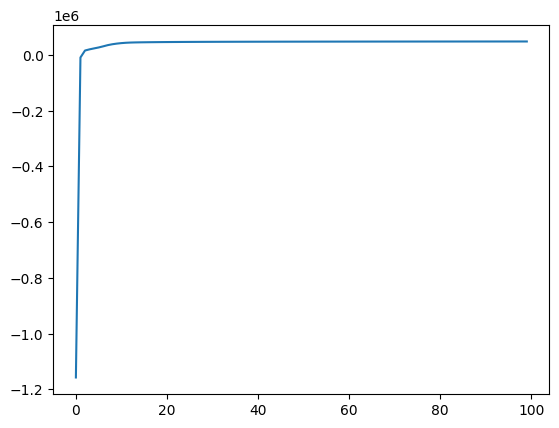

In [7]:
from models import ParamswGPLDS


seed = 1
A_key, b_key, C_key = jxr.split(jxr.PRNGKey(seed), 3)

conditions = theta

initial_params = ParamswGPLDS(
    dynamics_gp_weights = A_prior.weights(A_key),
    Q = 0.05 * jnp.eye(latent_dim),
    R = 0.05 * jnp.eye(n_neurons),
    m0 = jnp.zeros(latent_dim),
    S0 = jnp.eye(latent_dim),
    Cs = jnp.tile(jxr.normal(C_key, (n_neurons, 2)), (num_timesteps, 1, 1)),
    bs = b_prior.sample(b_key, conditions).squeeze(),
)
thetas_train = jnp.tile(conditions, (B, 1))[:partition]
params, log_probs = model.fit_em(initial_params, emissions=Y_train, inputs=thetas_train, num_iters=100)

plt.plot(log_probs)

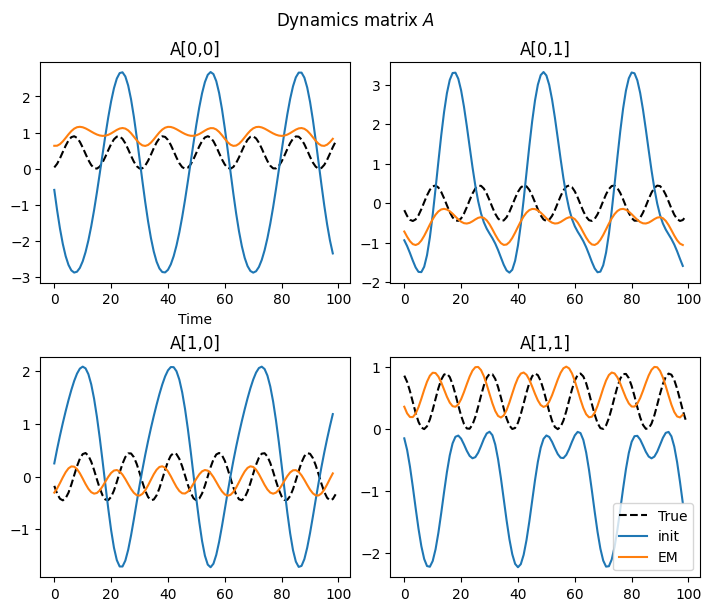

In [8]:
fig, axs = plt.subplots(ncols=latent_dim, nrows=latent_dim, figsize=(7, 6), constrained_layout=True);

for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        ax.plot(true_As[:,i,j], 'k--', label='True')
        ax.plot(A_prior(initial_params.dynamics_gp_weights, theta[:-1])[:,i,j], label='init')
        ax.plot(A_prior(params.dynamics_gp_weights, theta[:-1])[:,i,j], label='EM')
        ax.set_title(f'A[{i},{j}]')
axs[0,0].set_xlabel('Time')
ax.legend()
fig.suptitle('Dynamics matrix $A$');

Text(0.5, 0, 'Time')

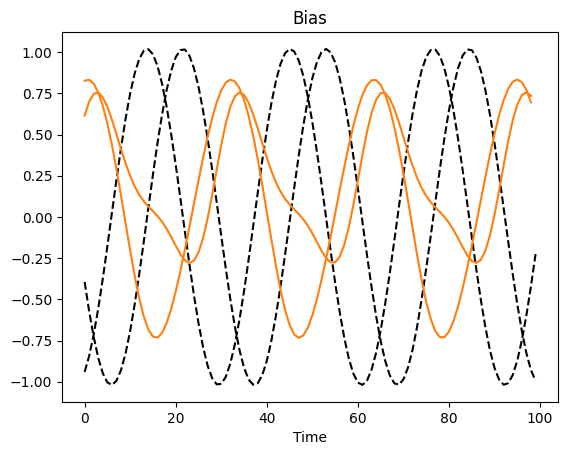

In [9]:
fig, ax = plt.subplots()
ax.plot(true_bs,'k--', label='True');
ax.plot(params.bs, c='tab:orange', label='EM');
ax.set_title("Bias")
ax.set_xlabel('Time')

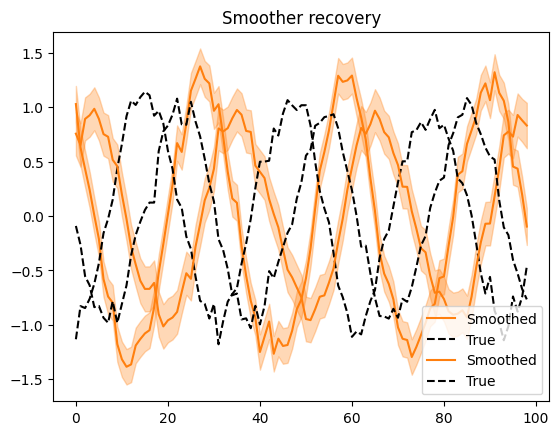

In [10]:
_, (filtered_means, _), (smoothed_means, smoothed_covs, _) = utils.lgssm_smoother(
    m0 = params.m0,
    S0 = params.S0,
    As = A_prior(params.dynamics_gp_weights, theta[:-1]),
    bs = params.bs,
    Cs = params.Cs,
    Q = noise_scale * jnp.eye(2),
    R = noise_scale * jnp.eye(n_neurons),
    ys = Y_train[0],
)

fig, ax = plt.subplots()
for i in range(2):
    ax.plot(smoothed_means[1:, i], color='tab:orange', label='Smoothed')
    ax.fill_between(
        jnp.arange(num_timesteps - 1),
        smoothed_means[1:, i] - 2 * jnp.sqrt(smoothed_covs[1:, i, i]),
        smoothed_means[1:, i] + 2 * jnp.sqrt(smoothed_covs[1:, i, i]),
        color='tab:orange',
        alpha=0.3,
    )
    ax.plot(X_train[0, 1:, i], 'k--', label='True')
ax.set_title('Smoother recovery')
ax.legend();

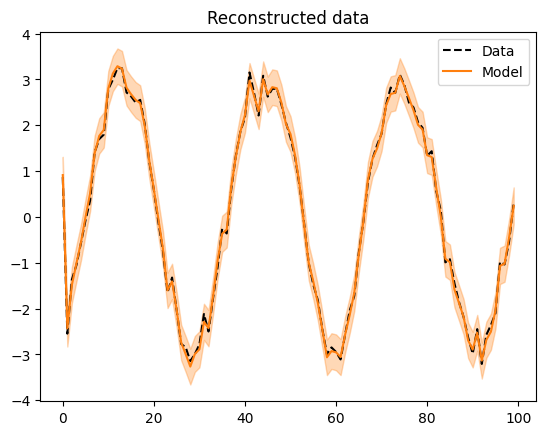

In [11]:
reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
reconstructed_ys_covs = jnp.einsum('tnl,tlk,tmk->tnm', params.Cs, smoothed_covs, params.Cs)

plt.plot(Y_train[0][:,2], c='k', ls='--', label='Data');
plt.plot(reconstructed_ys[:,2], c='tab:orange', label='Model');
plt.fill_between(
    jnp.arange(len(reconstructed_ys)),
    reconstructed_ys[:,2] - 2 * jnp.sqrt(reconstructed_ys_covs[:,2,2]),
    reconstructed_ys[:,2] + 2 * jnp.sqrt(reconstructed_ys_covs[:,2,2]),
    alpha=0.3, color='tab:orange',
)
plt.legend()
plt.title('Reconstructed data');

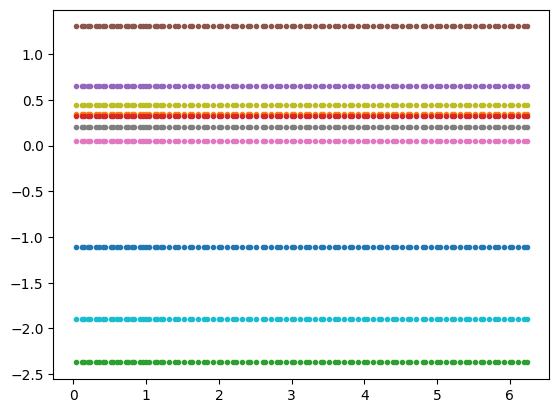

In [12]:
plt.plot(theta % (2 * jnp.pi), params.Cs[:,:,0], '.');